# Simulation models that include scheduling

Many health systems include a **scheduling** function.  This might for example be the scheduling of patient operations or appointments.  These systems are also queuing systems, but differ slightly from the systems we have already explored.  These models will need a **diary** to keep track of when patient events are scheduled and scheduling rules.  A scheduling rule might for example be limiting a specific type of operation to morning slots or to when a particular type of resource is available.  

**In this lab you will**

* Learn how to set up a basic **diary** structure for bookings in a simulation model
* See the approach in action in a simulation model that was used to support decision making in a mental health system


**Requirements**
* Please use the virtual environment `hds_stoch`

# Imports

In [1]:
import numpy as np
import pandas as pd
import simpy
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

sns.set()

simpy.__version__

'4.0.1'

The module `sim_utility.distributions` provides some distribution classes to help with the lab.

In [2]:
from sim_utility.distributions import (Bernoulli, Discrete, Poisson, 
                                       generate_seed_vector)

The module `sim_utility.scheduling_example` provides the modelling classes for the simulation modelling example we will use in this class.

In [3]:
from sim_utility.scheduling_example import (AssessmentReferralModel, 
                                            ScenarioArgs,
                                            results_summary)

# A scheduling example

This work a simpy implementation of a model reported in a book chapter 'Systems Modelling for Improving Healthcare' by *Pitt, Monks and Allen* (2015) https://bit.ly/3j8OH6y 

>The model was originally built by Dr Michael Allen in a commercial simulation software called Simul8 - a very powerful simulaton package.  One of the long term problems of using a commerical package in health research is that for the NHS to use the model themselves they must pay for a license (the cost varies by vendor, but will be in the region of £5k-£20k with an annual maintence/support fee in the region of £1k).  This is particularly difficult for the NHS!   The model used here is an open python and simpy implementation of the same model.  One additional benefit is that model runtime is shorter in simpy as the diary function is sped up through numpy and we lose some of the feature bloat associated with commerical software.  

## Waiting times for mental health assessment

The model was used to investigate the waiting times for mental health appointments in Devon.  These were assessment type appointments.  Patients who are unwell are referred to the service by General Practitioners in primary care.  There is an initial triage of referrals before booking an appointment.  Some of these patients are signposted to more appropriate services while others are are classified as low priority or high priority (depending on severity of illness) and booked into an assessment clinic.  In an ideal world, high priority patients are seen within 5 working days while low priority patients are seen within 20 days. As we will see to do that is challenging!  

The model simulates the clinics across Devon.  It includes 11 clinics - each of which has its own capacity that varies by day of week. 

>Note: the model simulates **indirect waiting time** for appointments.  That is the time between a referral and the the day of the appointment. It is not concerned with on the day waiting times (e.g. in a waiting room).

### Scheduling rules in the model 

#### Rule 1: Carve out
* When queuing systems are struggling an option is to **carve out** or hold back some capacity for higher priority patients.  This means that high priority patients have access to all appointment slots while low priority patients have access to only a fraction.

#### Rule 2: Home clinics
* At the beginning of this project the situation was as follows: if a Exeter patient was unwell they were referred to the Exeter clinic. That is a patient must attend their home clinic (they could only attend 1 clinic). This was done even if there was a clinic nearby that had an earlier appointment.  

#### Rule 3: Partial pooling appointments across clinics
* The objective of the modelling was to compare home clinic rule to a scenario where clinics worked together and pooled their appointments in a network.  For example, Exeter, Exmouth and Honiton might work together.  If a patient in Exeter was unwell they could then select the earlist appointment across these three clinics.

### Using the model

To run the model you need to create an instance of `AssessmentReferralModel` and pass it an instance of `ScenarioArgs`.  The latter is a container class that holds all of the model parameters.  The code below runs the model.  We will learn how some of the modelling works in this lab, but feel free to explore the code in `sim_utility.scheduling_example`.

In [4]:
help(AssessmentReferralModel)

Help on class AssessmentReferralModel in module sim_utility.scheduling_example:

class AssessmentReferralModel(builtins.object)
 |  AssessmentReferralModel(args)
 |  
 |  Implements the Mental Wellbeing and Access 'Assessment Referral'
 |  model in Pitt, Monks and Allen (2015). https://bit.ly/3j8OH6y
 |  
 |  Patients arrive at random and in proportion to the regional team.
 |  
 |  Patients may be seen by any team identified by a pooling matrix.  
 |  This includes limiting a patient to only be seen by their local team.  
 |  
 |  The model reports average waiting time and can be used to compare 
 |  full, partial and no pooling of appointments.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, args)
 |      Constructor
 |      
 |      Params:
 |      ------
 |      
 |      args: ScenarioArgs
 |          Arguments for the simulation model
 |  
 |  generate_arrivals(self)
 |      Time slicing simulation.  The model steps forward by a single
 |      day and simulates the number o

In [5]:
def single_run(args, rep=0):
    '''
    Perform as single run of the model and resturn results as a tuple.
    '''
    model = AssessmentReferralModel(args)
    model.run()
    
    return model.results_all, model.results_low, model.results_high

In [6]:
%%time
#depending on settings and CPU this model takes around 5-10 seconds to run 

#5 day a week model = 260 days a year
RESULTS_COLLECTION = 260 * 1

#We will learn about warm-up periods in a later lab.  We use one
#because the model starts up empty which doesn't reflect reality
WARM_UP = 260 * 3
RUN_LENGTH = RESULTS_COLLECTION + WARM_UP

#set up the scenario for the model to run.
args = ScenarioArgs(RUN_LENGTH, WARM_UP, seeds=generate_seed_vector())

#run model and return waiting time results split by priority
results_all, results_low, results_high = single_run(args)

#show a results summary
results_summary(results_all, results_low, results_high)

CPU times: user 4.23 s, sys: 15.5 ms, total: 4.24 s
Wall time: 4.24 s


,all,low_pri,high_pri
count,9441.000000,7872.000000,1569.000000
mean,23.578540,27.482851,3.989802
std,20.700226,20.447409,4.527681
min,1.000000,3.000000,1.000000
25%,6.000000,7.000000,1.000000
50%,13.000000,25.000000,2.000000
75%,43.000000,47.000000,5.000000
max,70.000000,70.000000,26.000000


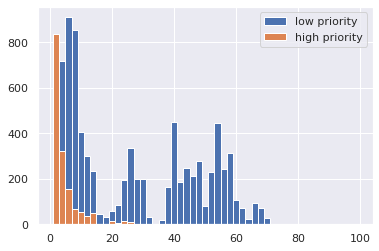

In [7]:
#histogram of low versus high priority

fig, ax = plt.subplots(1, 1)
ax.hist(results_low, bins=np.arange(1, 100, 2), label='low priority')
ax.hist(results_high, bins=np.arange(1, 100, 2), label='high priority')
ax.legend();

# Model input data

The model input data can be found in `data/`.

## Referrals across the clinics

On average, the service historically recieved around 16.3k patient referrals per year.  Given a 5 day working week this is ~60 patients referrals per day.  

There are three columns of data

* **prop** this is the proportion of 60 referrals per day that are to that particular clinic.  
* **referred_out** this is the proportion of the clinic referrals that are referred to an alternative service.
* **dna** this is the proportion of appointments where a patient **Did Not Attend** i.e. failed to turn up at the scheduled time.  

> We will ignore DNAs here as they they cannot be controlled.  However, notice that they are very high - up to 30%. In practice, we could explore scheduling with **overbooking** where more appointments are booked for a clinic than are available.  

In [8]:
pd.read_csv('data/referrals.csv')

,clinic,prop,referred_out,dna
0,1,0.111491,0.456,0.20
1,2,0.026346,0.428,0.25
2,3,0.196005,0.489,0.25
3,3,0.062220,0.296,0.20
4,4,0.025451,0.275,0.23
5,5,0.081302,0.091,0.21
6,6,0.057141,0.162,0.24
7,7,0.049271,0.129,0.17
8,8,0.125625,0.410,0.21
9,9,0.255356,0.361,0.30


## Clinic capacity

The clinics operate on a weekday (Mon-Fri) schedule.  Each clinic has its own capacity that varies by day of week.  You can interpret each integer value as the total number of appointments $a_{ij}$ available in clinic $i$ on week day $j$.

In [9]:
pd.read_csv('data/shifts.csv')

,clinic_1,clinic_2,clinic_3,clinic_4,clinic_5,clinic_6,clinic_7,clinic_8,clinic_9,clinic_10,clinic_11
0,4,1,7,3,1,5,3,3,5,11,1
1,4,1,6,3,1,5,3,3,5,10,0
2,4,1,7,3,2,5,4,3,5,11,1
3,4,1,6,3,1,5,3,3,5,10,1
4,4,1,6,2,1,4,3,2,4,10,0


## Pooling Matrix

By default the model is setup to send a patient to their home clinic (e.g. an Exeter patient is referred to Exeter's clinic).  When the model runs in **pooling** mode, a pooling matrix is used to determine which clinics a patient can access.  This is a simple table of 0s and 1s where 1 means a patient from clinic 1 can be sent to clinic 2.  The pooling matrix could be set up to any scenario. This includes full pooling where a patient is can access any clinic in Devon (not practical, but can be used as a comparator).


In [10]:
pd.read_csv('data/partial_pooling.csv')

,Unnamed: 0,clinic_1,clinic_2,clinic_3,clinic_4,clinic_5,clinic_6,clinic_7,clinic_8,clinic_9,clinic_10,clinic_11
0,clinic_1,1,1,1,0,0,0,0,0,0,0,0
1,clinic_2,1,1,1,0,0,0,0,0,0,0,0
2,clinic_3,1,1,1,1,1,0,0,0,1,0,0
3,clinic_4,0,0,0,1,1,1,0,0,0,0,0
4,clinic_5,0,0,0,1,1,1,0,0,0,0,0
5,clinic_6,0,0,0,1,1,1,1,0,0,0,0
6,clinic_7,0,0,0,0,0,1,1,0,0,0,0
7,clinic_8,0,0,0,0,0,0,0,1,1,1,1
8,clinic_9,0,0,1,0,0,0,0,1,1,1,0
9,clinic_10,0,0,0,0,0,0,0,0,1,1,0


# Exercise 1: creating a diary of available appointments

A simple way to keep track of available appointments and bookings in a simulation model is to have a diary matrix $D$ of size $T$ x $C$.  Where $T$ is measured in time units i.e. days and $C$ is the clinics.  For a simulation model with scheduling we will need $T$ be higher that the model run length $R$ as the model will be booking appointments right up to when it terminates. A simple rule might be $T = 1.5R$.

In the case of the mental health assessment referral model the the rows in $D$ will repeat every 5 days (because the clinics are open Mon-Fri and then repeat).  So you will actually need $\dfrac{1.5R}{5} - 1$ repeats of $D$

**Task:** 
* Using a run-length $R$ = 10 days, generate a diary for the referral model. 
* Generalise your code into a function so that you can work with any simple repeating schedule and $R$

**Hints**
* If you implement this in pandas you lose a bit of efficiency of NumPy, but it can make it easier to visualise the schedule.
* Investigate the `pd.concat()` function.
* You can think of the input data as a template that you can repeat when creating the diary.
* Once you have read the data in call the `.info()` function off of the dataframe.  Note that by default pandas uses the int64 dtype for the numeric fields.  That's an large amount of memory for the task as capacity is in the range of 1 - 20 (although its workable in this instance).  Can you reduce the memory requirements by using a different data type?



In [11]:
#to get you started the data is read into a dataframe
capacity_template = pd.read_csv('data/shifts.csv')
capacity_template

# your code here ...

,clinic_1,clinic_2,clinic_3,clinic_4,clinic_5,clinic_6,clinic_7,clinic_8,clinic_9,clinic_10,clinic_11
0,4,1,7,3,1,5,3,3,5,11,1
1,4,1,6,3,1,5,3,3,5,10,0
2,4,1,7,3,2,5,4,3,5,11,1
3,4,1,6,3,1,5,3,3,5,10,1
4,4,1,6,2,1,4,3,2,4,10,0


In [12]:
#example answer
def create_diary(run_length, capacity_template, units='day'):
    
    available_slots = capacity_template.copy()
        
    #longer than run length as patients will need to book ahead
    for day in range(int((run_length / 5) * 1.5 ) - 1):
        available_slots = pd.concat([available_slots, capacity_template.copy()], 
                                     ignore_index=True)

    available_slots.index.rename(units, inplace=True)
    return available_slots

In [13]:
#use dtype field to set to unsigned int8 - 0 to 255
capacity_template = pd.read_csv('data/shifts.csv', dtype=np.uint8)
available_slots = create_diary(run_length=10, 
                               capacity_template=capacity_template)
print(available_slots.info())

available_slots

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   clinic_1   15 non-null     uint8
 1   clinic_2   15 non-null     uint8
 2   clinic_3   15 non-null     uint8
 3   clinic_4   15 non-null     uint8
 4   clinic_5   15 non-null     uint8
 5   clinic_6   15 non-null     uint8
 6   clinic_7   15 non-null     uint8
 7   clinic_8   15 non-null     uint8
 8   clinic_9   15 non-null     uint8
 9   clinic_10  15 non-null     uint8
 10  clinic_11  15 non-null     uint8
dtypes: uint8(11)
memory usage: 293.0 bytes
None


,clinic_1,clinic_2,clinic_3,clinic_4,clinic_5,clinic_6,clinic_7,clinic_8,clinic_9,clinic_10,clinic_11
day,,,,,,,,,,,
0,4,1,7,3,1,5,3,3,5,11,1
1,4,1,6,3,1,5,3,3,5,10,0
2,4,1,7,3,2,5,4,3,5,11,1
3,4,1,6,3,1,5,3,3,5,10,1
4,4,1,6,2,1,4,3,2,4,10,0
5,4,1,7,3,1,5,3,3,5,11,1
6,4,1,6,3,1,5,3,3,5,10,0
7,4,1,7,3,2,5,4,3,5,11,1
8,4,1,6,3,1,5,3,3,5,10,1


## Exercise 2: Create a diary of bookings

**Task**:
* Create a diary called `bookings` - a pandas dataframe - that records the number of booked appointments for a given date and clinic.  
* Use a run length of 10 and assume that there are 11 clinics.
* Produce a generalised function to create a booked appointments diary.

**Hints**:
* A bookings diary should be $T$ x $C$ in size where $T = 1.5R$
* At the start of the simulation there are no bookings so all values need to be 0.
* Is there a quick method in NumPy that can help?

In [14]:
# your code here

In [15]:
#example solution

def create_bookings(run_length, n_clinics, units='day'):
    bookings = np.zeros(shape=(int(1.5*run_length), n_clinics), dtype=np.uint8)
    columns = [f'clinic_{i}' for i in range(1, n_clinics+1)]
    bookings = pd.DataFrame(bookings, columns=columns)
    bookings.index.rename('day', inplace=True)
    return bookings

In [16]:
capacity_template = pd.read_csv('data/shifts.csv', dtype=np.uint8)

#get the number of clinics
n_clinics = len(capacity_template.columns)

bookings = create_bookings(run_length=10, n_clinics=n_clinics)
bookings

,clinic_1,clinic_2,clinic_3,clinic_4,clinic_5,clinic_6,clinic_7,clinic_8,clinic_9,clinic_10,clinic_11
day,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0


# Finding an appointment and booking a slot

Assume that a patient is referred to the clinic 2 on $t=0$ of the simulation.  There are several tasks to complete in order to book a slot

1. Find the earliest available appointment slot for clinic 2.  This may be subject to a minimum delay e.g. in 1-3 working days.
2. Decrement the number of available slots on day 0 at clinic 2 by 1.
3. Increment the number of booked slots on day 0 at clinic 2 by 1.

## Incrementing and decrementing slots

Let's start with the incremement and decrementing of values as that is straightforward pandas.

For this worked example we will use the files `data/example_bookings.csv` and `data/example_available_slots.csv`.

In [17]:
bookings = pd.read_csv('data/example_bookings.csv', index_col='day')
bookings.head()

,clinic_1,clinic_2,clinic_3,clinic_4,clinic_5,clinic_6,clinic_7,clinic_8,clinic_9,clinic_10,clinic_11
day,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0


In [18]:
available_slots = pd.read_csv('data/example_available_slots.csv', 
                              index_col='day')
available_slots.head()

,clinic_1,clinic_2,clinic_3,clinic_4,clinic_5,clinic_6,clinic_7,clinic_8,clinic_9,clinic_10,clinic_11
day,,,,,,,,,,,
0,4,1,7,3,1,5,3,3,5,11,1
1,4,1,6,3,1,5,3,3,5,10,0
2,4,1,7,3,2,5,4,3,5,11,1
3,4,1,6,3,1,5,3,3,5,10,1
4,4,1,6,2,1,4,3,2,4,10,0


To update a cell in a pandas dataframe you can use the `.iat[row_index, col_index]` accessor. In our example assume that a patient on day 0 wants a slot at clinic 2.  There is a minimum wait of 3 days before an appointment can be booked.


In [19]:
clinic_index = 1 #clinic 2 is at index 1
t = 0
min_wait = 3

#decremement available slots 
available_slots.iat[t+min_wait, clinic_index] -= 1

available_slots.head()

,clinic_1,clinic_2,clinic_3,clinic_4,clinic_5,clinic_6,clinic_7,clinic_8,clinic_9,clinic_10,clinic_11
day,,,,,,,,,,,
0,4,1,7,3,1,5,3,3,5,11,1
1,4,1,6,3,1,5,3,3,5,10,0
2,4,1,7,3,2,5,4,3,5,11,1
3,4,0,6,3,1,5,3,3,5,10,1
4,4,1,6,2,1,4,3,2,4,10,0


We simply do the reverse for a confirmed booking.

In [20]:
clinic_index = 1 #clinic 2 is at index 1
t = 0
min_wait = 3

#decremement available slots 
bookings.iat[t+min_wait, clinic_index] += 1

bookings.head()

,clinic_1,clinic_2,clinic_3,clinic_4,clinic_5,clinic_6,clinic_7,clinic_8,clinic_9,clinic_10,clinic_11
day,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0


At all times `bookings + available_slots` equals the original capacity

In [21]:
(bookings + available_slots).head()

,clinic_1,clinic_2,clinic_3,clinic_4,clinic_5,clinic_6,clinic_7,clinic_8,clinic_9,clinic_10,clinic_11
day,,,,,,,,,,,
0,4,1,7,3,1,5,3,3,5,11,1
1,4,1,6,3,1,5,3,3,5,10,0
2,4,1,7,3,2,5,4,3,5,11,1
3,4,1,6,3,1,5,3,3,5,10,1
4,4,1,6,2,1,4,3,2,4,10,0


## Exercise 3: Finding the earliest available slot at the clinic.

**Task:**
* Create a function called `find_slot`
* The function should accept the parameters:
    * `available_slots` a `pandas.DataFrame` containing the diary/schedule
    * `t` an `int` representing the current time in days (corresponding to a row index in the diary)
    * `clinic_id` - an `int` representing the index of the clinic in the diary
    * `min_wait`- an `int` representing the minimum delay before an appointment can take place
* The function should return the day of the appointment and the clinic_id of the booking (in a tuple)
* Use the data `data/example_available_slots2.csv`
* Some test data:
    * t = 0, clinic_id = 0, min_wait = 1; result = (3, 0)
    * t = 3, clinic_id = 0, min_wait = 2; result = (5, 0)
    * t = 0, clinic_id = 1, min_wait = 1; result = (6, 1)
    * t = 4, clinic_id = 2, min_wait = 2; result = (7, 2) 
    
    
**Hints**
* You can code this either in pandas or numpy (the latter is more efficient!).  To drop to numpy call `to_numpy()` off of `available_slots`
* Remember you want slots in the future not the past!
* For a clinic you want the indexes of slots that have greater than zero slots.  Select the earliest of these.

In [22]:
#read it the data 
available_slots = pd.read_csv('data/example_available_slots2.csv', 
                              index_col='day')
available_slots.head()

#your code here ...

,clinic_1,clinic_2,clinic_3
day,,,
0,0,0,0
1,0,0,0
2,0,0,0
3,1,0,0
4,1,0,0


In [23]:
#example answer
def find_slot(available_slots, t, clinic_id, min_wait):
    '''
    Finds a slot in a diary of available slot

    Params:
    ------
    t: int,
        time t in days

    clinic_id: int
        clinic id is the index  of the clinic column in diary

    min_wait: int
        minimum number days a patient must wait before attending a booking
        
    Returns:
    ------
    (int, int)
    (booked_t, booked_clinic_id)
    '''
    #to reduce runtime drop to numpy
    available_slots_np = available_slots.to_numpy()

    #get the clinic slots t+min_wait forward for the pooled clinics
    clinic_slots = available_slots_np[t+min_wait:, clinic_id]

    #(booked_t, booked_clinic_id)
    return np.argmax(clinic_slots > 0) + min_wait + t, clinic_id

In [24]:
#change the params to see the results change.
t = 4
clinic_id = 2
min_wait = 2

available_slots = pd.read_csv('data/example_available_slots2.csv', 
                              index_col='day')

find_slot(available_slots, t, clinic_id, min_wait)

(7, 2)

# Pooled Booking

In the model booking logic is implemented in a set of Booking classes that encapsulate the varying logic of `book_slot(t, clinic_id)` and `find_slot(t, clinic_id)` (depending on the priority of a patient and if pooling of clinics is active)

For example, to work with pooled booking we would use `LowPriorityPooledBooker`.  We will work with a contrived dataset 'data/example_available_slots3.csv'

In [25]:
from sim_utility.scheduling_example import LowPriorityPooledBooker

In [26]:
#create an instance of the booker and pass in the simulation args
args = ScenarioArgs(run_length=5, 
                    slots_file='data/example_available_slots3.csv')

#parameters is just the scenario args
booker = LowPriorityPooledBooker(args)

If we take a look at the pooling matrix for **clinic 1** we can see that patients can also attend clinics 2 and 3.

In [27]:
pd.read_csv('data/partial_pooling.csv', index_col=0)['clinic_1']

clinic_1     1
clinic_2     1
clinic_3     1
clinic_4     0
clinic_5     0
clinic_6     0
clinic_7     0
clinic_8     0
clinic_9     0
clinic_10    0
clinic_11    0
Name: clinic_1, dtype: int64

If a patient with home clinic 1 (index 0) is referred at $t=0$ this is what the availabilty of slots looks like at the pooled clinics.

In [28]:
args.available_slots[['clinic_1','clinic_2', 'clinic_3']].head()

,clinic_1,clinic_2,clinic_3
day,,,
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,5
4,3,1,5


## Exercise 4: Use `LowPriorityPooledBooker`

Note: Low priority patients must wait a minimum of 3 days before taking a slot.

**Task**:
* Call the `booker.find_slot()` method and try the following refrerral parameters:
    * t = 0; clinic_id = 0
    * t = 0; clinic_id = 0
    * t = 1; clinic_id = 0
    
* Are you able to explain the results?

**Hints:**
* Remember that `find_slot()` does not actually book a slot.  It returns a tuple of `(best_t, best_clinic_id)`

In [29]:
# your code here...

In [30]:
#example answer
t = 0
home_clinic_id = 0
booker.find_slot(t, home_clinic_id)

(3, 1)

t = 0
home_clinic_id = 2
booker.find_slot(t, home_clinic_id)

In [31]:
t = 1
home_clinic_id = 0
booker.find_slot(t, home_clinic_id)

(4, 0)

# Exercise 5.  The simulation model.

## Exercise 5.1: Implementing a Patient Referrals class

We can consider each arrival to the system as a `PatientReferral`.  Some of these referrals are rejected if a more appropraite service is available.  The remaining referrals will use the current scheduling rules to find a slot and book it.

The code listing below provides skeleton and pseudo code for `PatientReferral`. The main method for finding and booking a slot is `execute()`.

**Task:**
* Complete the `PatientReferral.execute()` method below.  
* Your code should do the following
    1. find the best slot and clinic using `self.booker`
    2. book the best slot at the chosen clinic using `self.booker`
    3. use simpy's timeout functionality to schedule the completion of the process
    4. save the patients waiting time.
    
**Hints:**
* There is no need for the code to be complex.  There are just a few operations to complete.
* Remember this is a simpy process. So you should be using `yield` and `env.timeout(delay_value)`

In [32]:
class PatientReferral(object):
    '''
    Patient referral process
    
    Find an appropraite asessment slot for the patient.
    Schedule an assessment for that day.
    
    '''
    def __init__(self, env, args, referral_t, home_clinic, booker):
        '''
        Constructor
        
        Params:
        -------
        env: simpy.Environment
        
        args: ScenarioArgs
            - container class for model inputs and other useful
              objects
              
        referral_t: float:
            Time of referral
            
        home_clinic: int
            Clinic id in the same region as the patient
        
        booker: object
            Object that has an interface including
            book_slot(t, clinic_id) and find_slot(t, clinic_id).
            Used for finding and booking slots.
        '''
        
        self.env = env
        self.args = args
        self.referral_t = referral_t
        self.home_clinic = home_clinic
        
        self.booked_clinic = home_clinic
        self.booker = booker
                
        #performance metrics 
        self.waiting_time = None
    
    @property
    def priority(self):
        '''
        Return the priority of the patient booking
        '''
        return self.booker.priority
    
    def execute(self):
        '''
        Patient is referred to clinic
        
        1. find earliest slot within rules
        2. book slot at clinic
        3. schedule process to complete at that time
        '''
        
        #get best slot for clinic
        #YOUR CODE HERE ...
        
        #book slot at clinic = best_T
        #YOUR CODE HERE ....
            
        #wait for appointment
        #YOUR CODE HERE ...
        
        # measure waiting time on day of appointment
        #(could also record this before appointment, but leaving until 
        #afterwards allows modifications where patients can be moved)
        #YOUR CODE HERE ...

In [33]:
#example solution
class PatientReferral(object):
    '''
    Patient referral process
    
    Find an appropraite asessment slot for the patient.
    Schedule an assessment for that day.
    
    '''
    def __init__(self, env, args, referral_t, home_clinic, booker):
        '''
        Constructor
        
        Params:
        -------
        env: simpy.Environment
        
        args: ScenarioArgs
            - container class for model inputs and other useful
              objects
              
        referral_t: float:
            Time of referral
            
        home_clinic: int
            Clinic id in the same region as the patient
        
        booker: object
            Object that has an interface including
            book_slot(t, clinic_id) and find_slot(t, clinic_id).
            Used for finding and booking slots.
        '''
        self.env = env
        self.args = args
        self.referral_t = referral_t
        self.home_clinic = home_clinic
        self.booked_clinic = home_clinic
        self.booker = booker
                
        #performance metrics 
        self.waiting_time = None
    
    @property
    def priority(self):
        '''
        Return the priority of the patient booking
        '''
        return self.booker.priority
    
    def execute(self):
        '''
        Patient is referred to clinic
        
        1. find earliest slot within rules
        2. book slot at clinic
        3. schedule process to complete at that time
        '''
        #get best slot for clinic
        best_t, self.booked_clinic = \
            self.booker.find_slot(self.referral_t, self.home_clinic)
        
        #book slot at clinic = best_T
        self.booker.book_slot(best_t, self.booked_clinic)
            
        #wait for appointment
        yield self.env.timeout(best_t - self.referral_t)
        
        # measure waiting time on day of appointment
        #(could also record this before appointment, but leaving until 
        #afterwards allows modifications where patients can be moved)
        self.waiting_time = best_t - self.referral_t
        

## A look at the logic of `AssessmentReferralModel`

The code listing below contains the logic of `AssessmentReferralModel`.   Like all `simpy` models it contains a main generator loop to create processes.

Rather than simulating the time between arrivals the code takes a time slicing approach (fixed intervals of a day).  On each day a Poisson distribution (with mean ~60) is used to sample the **number** of arrivals during that day.  We can do this because we are not concerned with the time of arrival within the day.  Each arrival follows the same simulation process:

1. Sample home clinic 
2. Triage - is the patient referred out of system?
3. If the patients needs an appointments sample a priority
4. Use the priority to select the appropriate booking class 
5. Create a PatientReferral instance and execute the process.

This means there are two main loops.  Here's the first:

```python
for t in itertools.count():
    #day logic ...
```

this is an infinite loop (it loops until the simpy environment terminates) that increments a counter `t` that represents the day number.

The second loop is:

```python
    #sample the number of referrals today
    n_referrals = self.args.arrival_dist.sample()

    #loop through all referrals recieved that day
    for i in range(n_referrals):
        #referral logic ...
```

this samples from the daily arrival distribution (by default a Poisson) and assigns the result to `n_referrals`.  We use this to guide the second loop that executes the logic in points 1-5 above.

**1. sampling the home clinic**
```python
        #sample clinic based on empirical proportions
        clinic_id = self.args.clinic_dist.sample()
        
        #arg.clinics is a list of Clinic objects
        clinic = self.args.clinics[clinic_id]
```

**2. triaging the patient to see if they are referred to another service**

This uses `clinic` which contains the probability of referral for the individual clinic.

```python
        #triage patient and refer out of system if appropraite
        referred_out = clinic.ref_out_dist.sample()
```

**3. If the patients needs an appointments sample a priority**

```python
        #if patient is accepted to clinic
        if referred_out == 0: 

            #is patient high priority?
            high_priority = self.args.priority_dist.sample()
```


**4. Use the priority to select the appropriate booking class**

The `args` instance has an bool attribute called `pooling`.  This is used to control the behaviour of the model (False = no pooling; True = use the pooling matrix)

```python
            if high_priority == 1:
                #different policy if pooling or not
                if self.args.pooling:
                    booker = HighPriorityPooledBooker(self.args)
                else:
                    booker = HighPriorityBooker(self.args)
            else:
                #different policy if pooling or not
                if self.args.pooling:
                    booker = LowPriorityPooledBooker(self.args)
                else:
                    booker = LowPriorityBooker(self.args)
```

**5. Create a PatientReferral instance and execute the process.**
```python
            #create instance of PatientReferral
            patient = PatientReferral(self.env, self.args, t, 
                                      clinic_id, booker)

            #start a referral assessment process for patient.
            self.env.process(patient.execute())
```

The full code listing is below.

In [34]:
from sim_utility.scheduling_example import (HighPriorityBooker, 
                                            LowPriorityBooker,
                                            LowPriorityPooledBooker,
                                            HighPriorityPooledBooker)

In [35]:
class AssessmentReferralModel(object):
    '''
    Implements the Mental Wellbeing and Access 'Assessment Referral'
    model in Pitt, Monks and Allen (2015). https://bit.ly/3j8OH6y
    
    Patients arrive at random and in proportion to the regional team.
    
    Patients may be seen by any team identified by a pooling matrix.  
    This includes limiting a patient to only be seen by their local team.  
    
    The model reports average waiting time and can be used to compare 
    full, partial and no pooling of appointments.
    
    '''
    def __init__(self, args):
        '''
        Constructor
        
        Params:
        ------
        
        args: ScenarioArgs
            Arguments for the simulation model
    
        '''
        self.env = simpy.Environment()
        self.args = args
        
        #list of patients referral processes 
        self.referrals = []
        
        #simpy processes
        self.env.process(self.generate_arrivals())
        
    def run(self):
        '''
        Conduct a single run of the simulation model.
        '''
        self.env.run(self.args.run_length)
        self.process_run_results()
    
    def generate_arrivals(self):
        '''
        Time slicing simulation.  The model steps forward by a single
        day and simulates the number of arrivals from a Poisson
        distribution.  The following process is then applied.
        
        1. Sample the region of the referral from a Poisson distribution
        2. Triage - is an appointment made for the patient or are they referred
        to another service?
        3. A referral process is initiated for the patient.
        
        '''
        #loop a day at a time.
        for t in itertools.count():
            
            #total number of referrals today
            n_referrals = self.args.arrival_dist.sample()
            
            #loop through all referrals recieved that day
            for i in range(n_referrals):
                
                #sample clinic based on empirical proportions
                clinic_id = self.args.clinic_dist.sample()
                clinic = self.args.clinics[clinic_id]
                
                #triage patient and refer out of system if appropraite
                referred_out = clinic.ref_out_dist.sample()
                
                #if patient is accepted to clinic
                if referred_out == 0: 
                
                    #is patient high priority?
                    high_priority = self.args.priority_dist.sample()
                
                    if high_priority == 1:
                        #different policy if pooling or not
                        if self.args.pooling:
                            booker = HighPriorityPooledBooker(self.args)
                        else:
                            booker = HighPriorityBooker(self.args)
                    else:
                        #different policy if pooling or not
                        if self.args.pooling:
                            booker = LowPriorityPooledBooker(self.args)
                        else:
                            booker = LowPriorityBooker(self.args)
                
                    #create instance of PatientReferral
                    patient = PatientReferral(self.env, self.args, t, 
                                              clinic_id, booker)
                    
                    #start a referral assessment process for patient.
                    self.env.process(patient.execute())
                                        
                    #only collect results after warm-up complete
                    if self.env.now > self.args.warm_up_period:
                        #store patient for calculating waiting time stats at end
                        self.referrals.append(patient)
            
            #timestep by one day
            yield self.env.timeout(1)
            
    def process_run_results(self):
        '''
        Produce summary results split by priority...
        '''
        
        results_all = [p.waiting_time for p in self.referrals 
               if not p.waiting_time is None]

        results_low = [p.waiting_time for p in self.referrals 
                       if not (p.waiting_time is None) and p.priority == 1]

        results_high = [p.waiting_time for p in self.referrals 
                       if (not p.waiting_time is None) and p.priority == 2]
        
        self.results_all = results_all
        self.results_low = results_low
        self.results_high = results_high

## Exercise 5.2 Pulling it all together and running scenarios

Let's do three single runs of the model.  Each run will be a scenario.   

1. A base run.  In the first scenario we will use the default settings.  
2. Partial pooling with carve out. In the second run we will set `ScenarioArgs.pooling = True`.  
3. Patient pooling with no carve out.  In the third run we will set `ScenarioArgs.prop_carve_out=0.0` AND `ScenarioArgs.pooling = True`. 

**Task:**
* Modify the code listing below so that it runs three scenarios.
* After you have run the two scenarios show the two result summaries.
* After running the model what do you think of the options?

**Hints**:
* Make sure the code below executes correctly first.  If it fails then there is likely an issue in your custom `PatientReferral` class.
* Take a look at the constructor method of ScenarioArgs.  This accepts a parameter called `pooling` (default=False).  Set this to `True` for the second and third scenarios. It also accepts a parameter `prop_carve_out`.  Set this to 0.0 in the third scenario.

In [36]:
%%time
#depending on settings and CPU this model takes around 5-10 seconds to run 

#5 day a week model = 260 days a year
RESULTS_COLLECTION = 260 * 1

#We will learn about warm-up periods in a later lab.  We use one
#because the model starts up empty which doesn't reflect reality
WARM_UP = 260 * 3
RUN_LENGTH = RESULTS_COLLECTION + WARM_UP

#set up the scenario for the model to run.
args = ScenarioArgs(RUN_LENGTH, WARM_UP, seeds=generate_seed_vector())

#run model and return waiting time results split by priority
results_all, results_low, results_high = single_run(args)

#show a results summary
results_summary(results_all, results_low, results_high)

CPU times: user 4.34 s, sys: 0 ns, total: 4.34 s
Wall time: 4.34 s


,all,low_pri,high_pri
count,9441.000000,7872.000000,1569.000000
mean,23.578540,27.482851,3.989802
std,20.700226,20.447409,4.527681
min,1.000000,3.000000,1.000000
25%,6.000000,7.000000,1.000000
50%,13.000000,25.000000,2.000000
75%,43.000000,47.000000,5.000000
max,70.000000,70.000000,26.000000


In [37]:
%%time
#example solution...

#depending on settings and CPU this model takes around 15-20 seconds to run 

#5 day a week model = 260 days a year
RESULTS_COLLECTION = 260 * 1

#We will learn about warm-up periods in a later lab.  We use one
#because the model starts up empty which doesn't reflect reality
WARM_UP = 260 * 3
RUN_LENGTH = RESULTS_COLLECTION + WARM_UP

#set up the scenario for the model to run.
scenarios = {}
scenarios['as-is'] = ScenarioArgs(RUN_LENGTH, WARM_UP, 
                                 seeds=generate_seed_vector())
scenarios['pooled'] = ScenarioArgs(RUN_LENGTH, WARM_UP, pooling=True,
                                   seeds=generate_seed_vector())
scenarios['no_carve_out'] = ScenarioArgs(RUN_LENGTH, WARM_UP, pooling=True, 
                                         prop_carve_out=0.0, 
                                         seeds=generate_seed_vector())

for name, args in scenarios.items():
    print(f'Running Scenario: {name}', end=' => ')
    #run model and return waiting time results split by priority
    results_all, results_low, results_high = single_run(args)
    print(f'done.\n{name} results:')
    #show a results summary
    print(results_summary(results_all, results_low, results_high))
    print('\n')

Running Scenario: as-is => done.
as-is results:
               all      low_pri     high_pri
count  9441.000000  7872.000000  1569.000000
mean     23.578540    27.482851     3.989802
std      20.700226    20.447409     4.527681
min       1.000000     3.000000     1.000000
25%       6.000000     7.000000     1.000000
50%      13.000000    25.000000     2.000000
75%      43.000000    47.000000     5.000000
max      70.000000    70.000000    26.000000


Running Scenario: pooled => done.
pooled results:
                all      low_pri     high_pri
count  10392.000000  8815.000000  1577.000000
mean       3.901848     4.183551     2.327204
std        1.187052     0.884209     1.411780
min        1.000000     3.000000     1.000000
25%        3.000000     4.000000     1.000000
50%        4.000000     4.000000     2.000000
75%        5.000000     5.000000     3.000000
max        7.000000     7.000000     7.000000


Running Scenario: no_carve_out => done.
no_carve_out results:
                a

# End of Lab.